## The Project: Statistical Analysis of Network Capture File

This project performs a **general statistical analysis** of a network capture (PCAP) file. The analysis includes:

* **Protocol distribution**: Visualizing the most common protocols using a pie/donut chart.
* **Top 10 Protocols**: Identifying and displaying which protocols dominate the traffic.
* **Readable Visualization**: The chart layout is optimized to reduce whitespace and enhance readability (percentages shown in the legend).

The goal is to provide a **quick visual summary** of traffic patterns and dominant protocols in the capture file.



# What Is a PCAP File and Why Is It Important in Cybersecurity Investigations?

## What Is a PCAP File?

A **PCAP file** (Packet Capture file) is a digital recording of network traffic.  
It contains raw data packets as they were transmitted over a network — including:

- **Source and destination IP addresses**
- **Ports**
- **Protocols (TCP, UDP, DNS, HTTP, etc.)**
- **Payloads** (if unencrypted)
- **Timestamps**

PCAP files are typically generated using tools like:
- `tcpdump`
- `Wireshark`
- `TShark`
- `Zeek` (with `pcap` input)

The file format stores each packet in sequence, allowing replay or analysis of the full communication.


## The data: UNSW-NB15 PCAP – 17-2-2015_27

This PCAP file contains **network traffic captured on February 17, 2015**, as part of the **UNSW-NB15 benchmark dataset** — a modern intrusion detection dataset designed to reflect both normal and malicious traffic.

### Key Characteristics:

* Captured in a controlled lab environment using the **IXIA PerfectStorm** tool.
* Includes a variety of protocols such as TCP, UDP, DNS, HTTP, and raw data.
* Contains both **benign traffic** and **attacks** like DoS, Exploits, Reconnaissance, etc.
* Time-sequenced packet data, suitable for:

  * Flow generation
  * Protocol analysis
  * Payload inspection
  * Feature extraction for ML models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
# Copy file to working directory
!cp "/content/drive/MyDrive/Portfolio datasets/cyber/UNSW-NB15-dataset_pcap-files_pcaps 17-2-2015_27.pcap" ./unsw_sample.pcap

## What the Data Tells Us

This summary provides a **quick statistical overview** of the first 20,000 parsed network packets from the PCAP file.

### Key Insights:

* **Parsed packets**: `20,000` network packets were successfully parsed.
* **Total traffic**: ~**9.4 MB** of data.
* **Source IPs**: Traffic originated from **35 unique IP addresses**.
* **Destination IPs**: Packets were sent to **32 unique IPs**.

### Protocol Breakdown (Simplified):

* **Raw and TCP** – Most of the traffic involves basic data transmission between devices.
* **DNS and BOOTP** – These protocols are used for resolving device names (DNS) and discovering devices on the network (BOOTP).
* **SMB and Padding** – May indicate file-sharing activity or the presence of older legacy systems on the network.


In [ ]:
# Colab cell: fast using scapy (recommended)
# Install scapy if missing
!pip install -q scapy pandas tqdm

from scapy.all import rdpcap
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import os

pcap_path = "/content/unsw_sample.pcap"
limit = 20000
out_csv = "/content/unsw_sample_20000_summary.csv"

# rdpcap supports 'count' to read up to that many packets
print("Loading up to", limit, "packets from", pcap_path)
pkts = rdpcap(pcap_path, count=limit)  # reads at most `limit` packets

rows = []
for pkt in tqdm(pkts, desc="parsing packets"):
    try:
        ts = pkt.time if hasattr(pkt, "time") else None
        # try to extract IP if present
        src = pkt[1].src if pkt.haslayer("IP") else (pkt[0].src if hasattr(pkt[0], "src") else None)
        dst = pkt[1].dst if pkt.haslayer("IP") else (pkt[0].dst if hasattr(pkt[0], "dst") else None)
        proto = pkt.lastlayer().name if pkt.layers() else None
        length = len(pkt)
        rows.append({
            "time": ts,
            "src": src,
            "dst": dst,
            "protocol": proto,
            "length": length
        })
    except Exception:
        continue

df = pd.DataFrame(rows)
if df.empty:
    print("No packets parsed (maybe non-IP packets).")
else:
    # convert times
    df['time_dt'] = pd.to_datetime(df['time'], unit='s', errors='coerce')
    start_time = df['time_dt'].min()
    end_time = df['time_dt'].max()
    duration = (end_time - start_time) if pd.notnull(start_time) and pd.notnull(end_time) else None

    print("Parsed packets:", len(df))
    print("Start:", start_time)
    print("End  :", end_time)
    print("Duration:", duration)
    print("Total bytes:", df['length'].sum())
    print("Unique src IPs:", df['src'].nunique())
    print("Unique dst IPs:", df['dst'].nunique())
    print("Top protocols:\n", df['protocol'].value_counts().head(10))

    df.to_csv(out_csv, index=False)
    print("Saved summary CSV to:", out_csv)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 16.2 MB/s eta 0:00:00
Loading up to 20000 packets from /content/unsw_sample.pcap


parsing packets: 100%|██████████| 20000/20000 [00:00<00:00, 34581.09it/s]


Parsed packets: 20000
Start: NaT
End  : NaT
Duration: None
Total bytes: 9411976
Unique src IPs: 35
Unique dst IPs: 32
Top protocols:
 protocol
Raw                                                   10012
TCP                                                    9504
DNS                                                     232
Padding                                                 212
SMB Negotiate Extended Security Response (SMB)           18
SMB Negotiate Request                                    16
Session Setup AndX Extended Security Request (SMB)        4
BOOTP                                                     2
Name: count, dtype: int64
Saved summary CSV to: /content/unsw_sample_20000_summary.csv


## Step 2: Top 20 Source IPs by Packet Count

### Why Source IP Analysis Matters in Cyber Investigations

Identifying the top **source IP addresses** provides crucial insights in network forensics:

* **Detecting Anomalies**: If one IP sends a very large number of packets, it could indicate scanning, brute-force attacks, or malware activity.
* **Attribution**: Source IPs help trace where suspicious traffic originated from (internally or externally).
* **Network Mapping**: Reveals which devices are most active, helping to distinguish normal behavior from potential threats.
* **Prioritization**: Investigators can focus on top talkers to reduce investigation time and isolate malicious actors quickly.
* **Baseline Behavior**: Comparing current source IP patterns to known baselines helps spot abnormal activity early.

In summary, this analysis helps **narrow down suspects, detect suspicious patterns, and guide further investigation** efficiently.

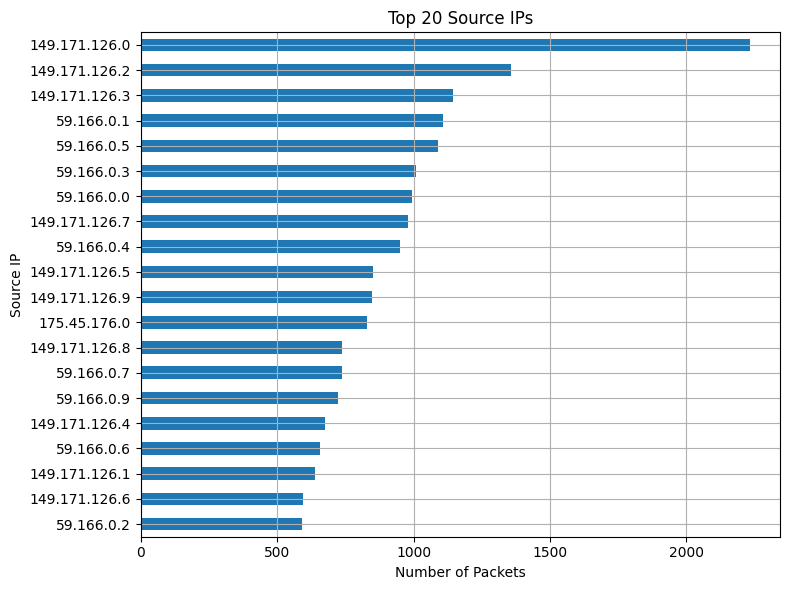

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the summary CSV
df = pd.read_csv("/content/unsw_sample_20000_summary.csv")

# Count top 20 source IPs
top_src = df['src'].value_counts().head(20)


# Plot bar chart
top_src.plot(kind='barh', figsize=(8, 6), title='Top 20 Source IPs')
plt.xlabel("Number of Packets")
plt.ylabel("Source IP")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


### Step 3: Traffic Volume Over Time (Bytes / 10s)

#### Why It’s Important for Investigation:

* **Detecting anomalies**: Sudden spikes or drops in traffic may indicate potential attacks such as DDoS, data exfiltration, or unexpected service behavior.
* **Timeline correlation**: Helps align traffic patterns with other logs (e.g., authentication events, system alerts).
* **Focus area for deep dive**: Investigators can zoom into suspicious time windows in the PCAP file instead of analyzing the entire capture.
* **Identify automation or scanning**: Regular traffic pulses could indicate malware activity, bot scans, or scripted tasks.
* **Baseline behavior understanding**: Visualizes what "normal" traffic looks like for this environment and highlights deviations.

#### Summary:

This time-series chart gives investigators a **quick visual overview** of network load over time and helps identify **when** something unusual might have occurred. It serves as an effective entry point for deeper traffic analysis.

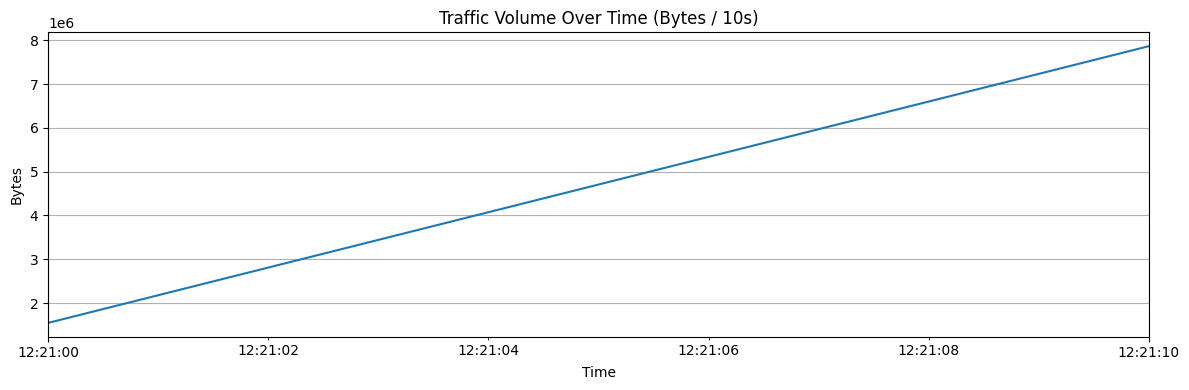

In [ ]:
# Convert time to datetime
df['time_dt'] = pd.to_datetime(df['time'], unit='s', errors='coerce')
df = df.dropna(subset=['time_dt'])

# Set datetime index
df.set_index('time_dt', inplace=True)

# Sum of bytes per 10-second interval
traffic_per_interval = df['length'].resample('10s').sum()

# Plot time-series
traffic_per_interval.plot(figsize=(12, 4), title="Traffic Volume Over Time (Bytes / 10s)")
plt.xlabel("Time")
plt.ylabel("Bytes")
plt.grid()
plt.tight_layout()
plt.show()


### Top 20 Destination IPs – Why This Matters for Investigation

#### Why It's Useful for Investigation:

* **Identifies high-interest targets**
  Helps detect which devices or servers received the most traffic — these may include key assets or suspicious remote addresses.

* **Detects suspicious endpoints**
  If a destination IP is unexpected or unknown, but receives a large volume of packets, this may indicate:

  * **Data exfiltration**
  * **Malware contacting external servers (C2 activity)**
  * **Unauthorized data access**

* **Signals horizontal movement or reconnaissance**
  This means an attacker may be **scanning internal IPs** or **moving laterally** between machines inside the network.
  Examples:

  * A single source sends packets to many different destination IPs.
  * Multiple internal devices are contacted in a short time span.

  Such behavior often indicates the attacker is **mapping the network**, **probing vulnerabilities**, or **trying to spread** across machines after an initial compromise.

* **Focuses analyst attention**
  Instead of reviewing thousands of IPs, analysts can immediately focus on the most active or suspicious destinations.

#### Summary:

This code provides a **fast, targeted view of communication patterns**, helping analysts identify anomalies, validate known infrastructure, and uncover malicious behavior — such as **internal scanning**, **targeted attacks**, or **unusual traffic spikes**.


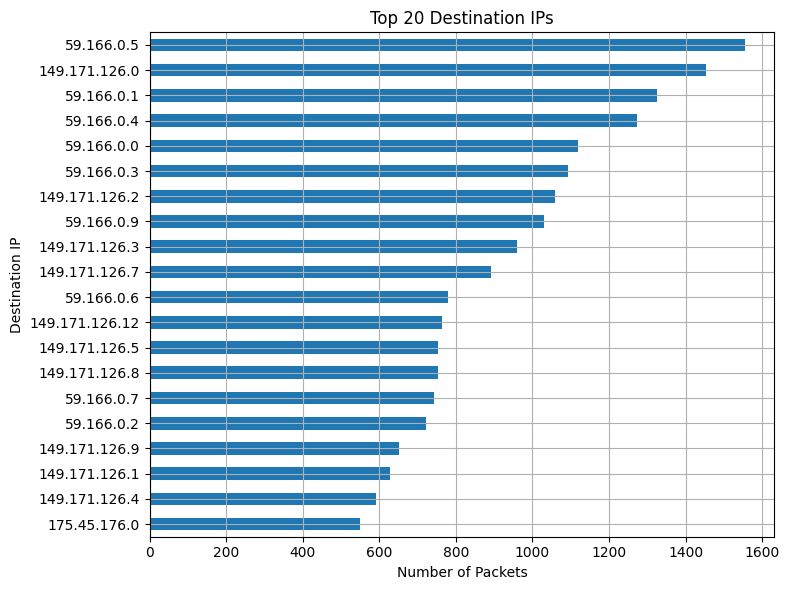

In [ ]:
# Count top 20 destination IPs
top_dst = df['dst'].value_counts().head(20)


# Plot bar chart
top_dst.plot(kind='barh', figsize=(8, 6), title='Top 20 Destination IPs')
plt.xlabel("Number of Packets")
plt.ylabel("Destination IP")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


### Protocol Usage Overview – Top 10 Protocols


#### What the Chart Shows:

* **Raw (50.1%)** and **TCP (47.5%)** dominate the traffic — indicating mostly raw and transport-layer activity.
* Smaller percentages include:

  * **DNS (1.2%)** – name resolution
  * **Padding, SMB, BOOTP** – hints of file sharing, older protocols, or device discovery
* The **legend next to the chart** provides clear labels with exact percentages.

#### Why This Matters:

* Investigators can **quickly assess protocol usage patterns**.
* **Unusual protocols or volume spikes** (e.g., high SMB or BOOTP) may hint at:

  * Malware spreading
  * Legacy services
  * Lateral movement in the network



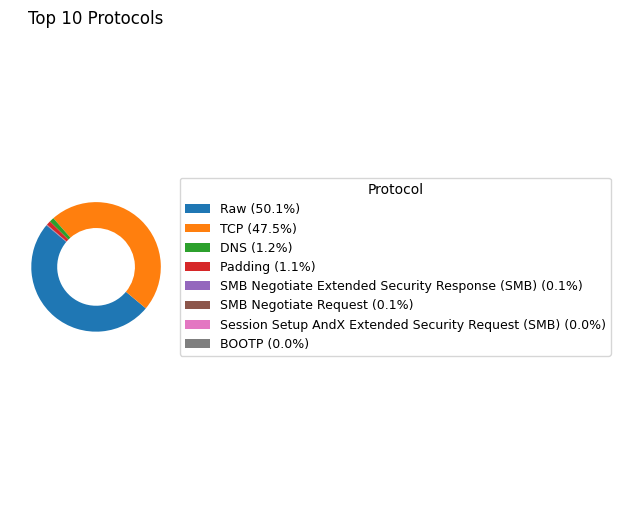

In [ ]:
import matplotlib.pyplot as plt

# Count top 10 protocols
protocol_counts = df['protocol'].value_counts().head(10)
protocol_labels = protocol_counts.index
protocol_sizes = protocol_counts.values
protocol_percent = protocol_sizes / protocol_sizes.sum() * 100

# Custom legend labels: "ProtocolName (12.3%)"
custom_labels = [f"{label} ({percent:.1f}%)" for label, percent in zip(protocol_labels, protocol_percent)]

# Create tighter figure
fig, ax = plt.subplots(figsize=(6, 5))  # Smaller figsize

# Plot as donut chart
wedges, _ = ax.pie(
    protocol_sizes,
    startangle=140,
    wedgeprops=dict(width=0.4),
    labels=None
)

# Add compact legend
ax.legend(
    wedges,
    custom_labels,
    title="Protocol",
    loc="center left",
    bbox_to_anchor=(0.95, 0.5),  # Moves legend closer to pie
    fontsize=9
)

# Set layout and remove extra whitespace
plt.title("Top 10 Protocols", pad=10)
plt.axis('equal')              # Keep circle shape
plt.tight_layout(pad=0.5)      # Minimal padding
plt.show()


### DNS IP Analysis for Investigation

This code helps investigators by showing:

* **Top source IPs** making DNS requests
  → Helps identify which devices are actively looking up domains.

* **Top destination IPs** receiving DNS traffic
  → Reveals which DNS servers are being used.

#### Why it matters:

* Detect **unusual DNS behavior** (e.g., internal devices querying unknown servers)
* Spot signs of **data exfiltration or tunneling** via DNS
* Find **misconfigured or compromised hosts**

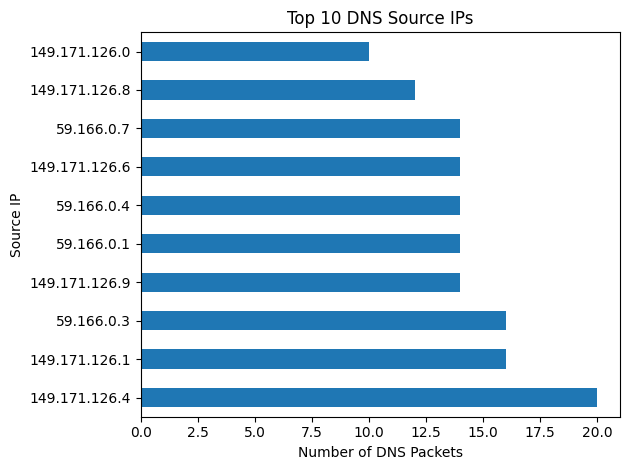

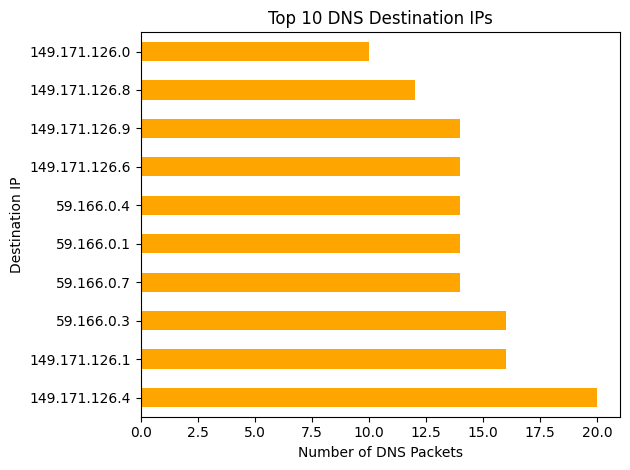

In [ ]:
# Filter DNS packets
dns_df = df[df['protocol'] == 'DNS']
# Top 10 DNS source IPs
dns_df['src'].value_counts().head(10).plot.barh(title='Top 10 DNS Source IPs')
plt.xlabel("Number of DNS Packets")
plt.ylabel("Source IP")
plt.tight_layout()
plt.show()

# Top 10 DNS destination IPs
dns_df['dst'].value_counts().head(10).plot.barh(title='Top 10 DNS Destination IPs', color='orange')
plt.xlabel("Number of DNS Packets")
plt.ylabel("Destination IP")
plt.tight_layout()
plt.show()


### Source-Destination Flow Heatmap – Investigation Insight

#### What the Heatmap Shows

* Rows = **Source IPs** (who is sending)
* Columns = **Destination IPs** (who is receiving)
* Cell color = **How much traffic** was sent between each pair

#### Why This Is Useful in Cyber Investigations

* **Detect anomalies**: One IP talking to many others can suggest scanning or lateral movement
* **Spot command-and-control (C2)**: A destination with many sources talking to it could be a beacon target
* **Identify communication hubs**: Unusual patterns (very dark cells or concentrated blocks) may indicate infected hosts, data exfiltration, or internal spreading

#### In This Case

From the attached heatmap:

* A few **source-destination pairs** have very high traffic (dark blue squares)
* Some **IPs communicate with many others**, suggesting **broadcasting**, scanning, or central coordination
* One source (e.g., `149.171.126.9`) shows significantly more communication with several destinations → possibly worth investigating


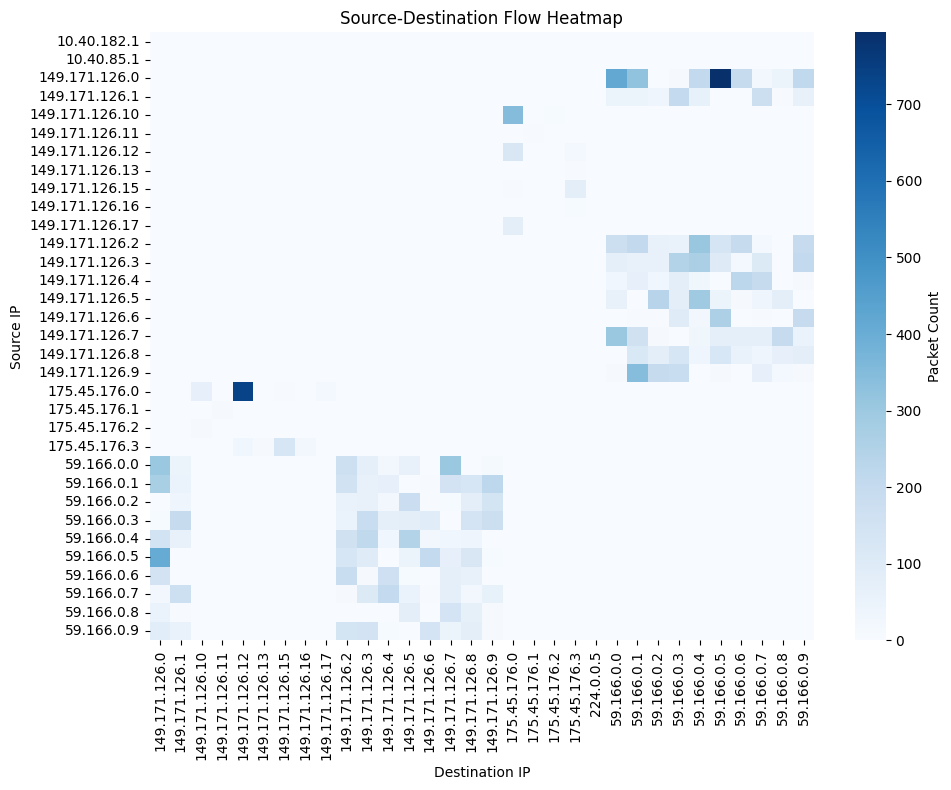

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by (src, dst) and count
flow_counts = df.groupby(['src', 'dst']).size().reset_index(name='count')

# Sort by highest counts
flow_counts_sorted = flow_counts.sort_values(by='count', ascending=False)
# Optional: pivot table as matrix (not plotted)
flow_matrix = flow_counts.pivot_table(index='src', columns='dst', values='count', fill_value=0)


plt.figure(figsize=(10,8))
sns.heatmap(flow_matrix, cmap="Blues", cbar_kws={'label': 'Packet Count'})
plt.title("Source-Destination Flow Heatmap")
plt.xlabel("Destination IP")
plt.ylabel("Source IP")
plt.tight_layout()
plt.show()
